In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pytz
import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Import et indexation #

In [3]:
df_source = pd.read_csv("sources/2_conso_elec_no_trend.csv")

In [4]:
# On va utiliser une colonne date, au bon format, pour visualisation Fourier. En plus de l'index (lui aussi date)
df_source["Date_parsed"] = pd.to_datetime(df_source["Date"], utc=True)
# On repasse donc en heure FR
df_source["Date_parsed"] = df_source["Date_parsed"].dt.tz_convert('Europe/Paris')

In [6]:
df_source.set_index('Date',inplace=True)
df_source.head(1)

Conso_elec_totale_MW  conso_elec_MW_no_trend  \
Date                                                                      
2012-05-01 00:00:00+02:00               51830.0            -3631.887424   

                                        Date_parsed  
Date                                                 
2012-05-01 00:00:00+02:00 2012-05-01 00:00:00+02:00

In [7]:
df_source.drop(columns=[])

Conso_elec_totale_MW  conso_elec_MW_no_trend  \
Date                                                                      
2012-05-01 00:00:00+02:00               51830.0            -3631.887424   
2012-05-01 00:30:00+02:00               49493.0            -5968.872009   
2012-05-01 01:00:00+02:00               46873.0            -8588.856594   
2012-05-01 01:30:00+02:00               46561.0            -8900.841179   
2012-05-01 02:00:00+02:00               46140.0            -9321.825764   
...                                         ...                     ...   
2022-05-31 21:30:00+02:00               44043.0            -8693.846828   
2022-05-31 22:00:00+02:00               44019.0            -8717.831413   
2022-05-31 22:30:00+02:00               45067.0            -7669.815998   
2022-05-31 23:00:00+02:00               46703.0            -6033.800583   
2022-05-31 23:30:00+02:00               45279.0            -7457.785168   

                                        Date_parsed  
Date                                                 
2012-05-01 00:00:00+02:00 2012-05-01 00:00:00+02:00  
2012-05-01 00:30:00+02:00 2012-05-01 00:30:00+02:00  
2012-05-01 01:00:00+02:00 2012-05-01 01:00:00+02:00  
2012-05-01 01:30:00+02:00 2012-05-01 01:30:00+02:00  
2012-05-01 02:00:00+02:00 2012-05-01 02:00:00+02:00  
...                                             ...  
2022-05-31 21:30:00+02:00 2022-05-31 21:30:00+02:00  
2022-05-31 22:00:00+02:00 2022-05-31 22:00:00+02:00  
2022-05-31 22:30:00+02:00 2022-05-31 22:30:00+02:00  
2022-05-31 23:00:00+02:00 2022-05-31 23:00:00+02:00  
2022-05-31 23:30:00+02:00 2022-05-31 23:30:00+02:00  

[176784 rows x 3 columns]

In [8]:
df_source.dtypes

Conso_elec_totale_MW                           float64
conso_elec_MW_no_trend                         float64
Date_parsed               datetime64[ns, Europe/Paris]
dtype: object

In [9]:
df_source.isna().sum()

Conso_elec_totale_MW      0
conso_elec_MW_no_trend    0
Date_parsed               0
dtype: int64

# Définition des fonctions #

In [10]:
# Apparence graphes Matplotlib
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [11]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [12]:
# Le periodogram aide à identifier quel ordre on doit adresser aux Series de Fourier

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


In [13]:
# Le periodogram aide à identifier quel ordre on doit adresser aux Series de Fourier

def plot_periodogram_h(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta(1,'hour')
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104, 208, 416, 832, 1664, 3328, 6656])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
            "2j (208)",
            "Daily (416)",
            "Demi-journée (832)",
            "Ttes 6h (1664)",
            "Ttes 3h (3328)",
            "Heure (6656)"
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [14]:
# Le détail de ce qui a importé importé via Calendar Fourier.
# Descriptif de la fonction ici : https://www.statsmodels.org/stable/generated/statsmodels.tsa.deterministic.CalendarFourier.html

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

# Représentation des Saisonalités #

In [15]:
# Pour cette visualisation, il sera necessaire d'extraire la valeur max quotidienne
X = df_source[["Date_parsed","conso_elec_MW_no_trend"]].groupby(
    pd.Grouper(key='Date_parsed', axis=0, freq='D')
    ).max()

In [16]:
# days within a week
X["annee"] = X.index.year
X["semaine"] = X.index.week  # the seasonal period (period)
X["jour_annee"] = X.index.dayofyear  # the x-axis (freq)
X["jour_semaine"] = X.index.dayofweek  # the x-axis (freq)

In [17]:
X.tail()

conso_elec_MW_no_trend  annee  semaine  jour_annee  \
Date_parsed                                                                     
2022-05-27 00:00:00+02:00            -5527.068554   2022       21         147   
2022-05-28 00:00:00+02:00            -8253.328636   2022       21         148   
2022-05-29 00:00:00+02:00            -8982.588718   2022       21         149   
2022-05-30 00:00:00+02:00            -1332.848800   2022       22         150   
2022-05-31 00:00:00+02:00             -886.108882   2022       22         151   

                           jour_semaine  
Date_parsed                              
2022-05-27 00:00:00+02:00             4  
2022-05-28 00:00:00+02:00             5  
2022-05-29 00:00:00+02:00             6  
2022-05-30 00:00:00+02:00             0  
2022-05-31 00:00:00+02:00             1

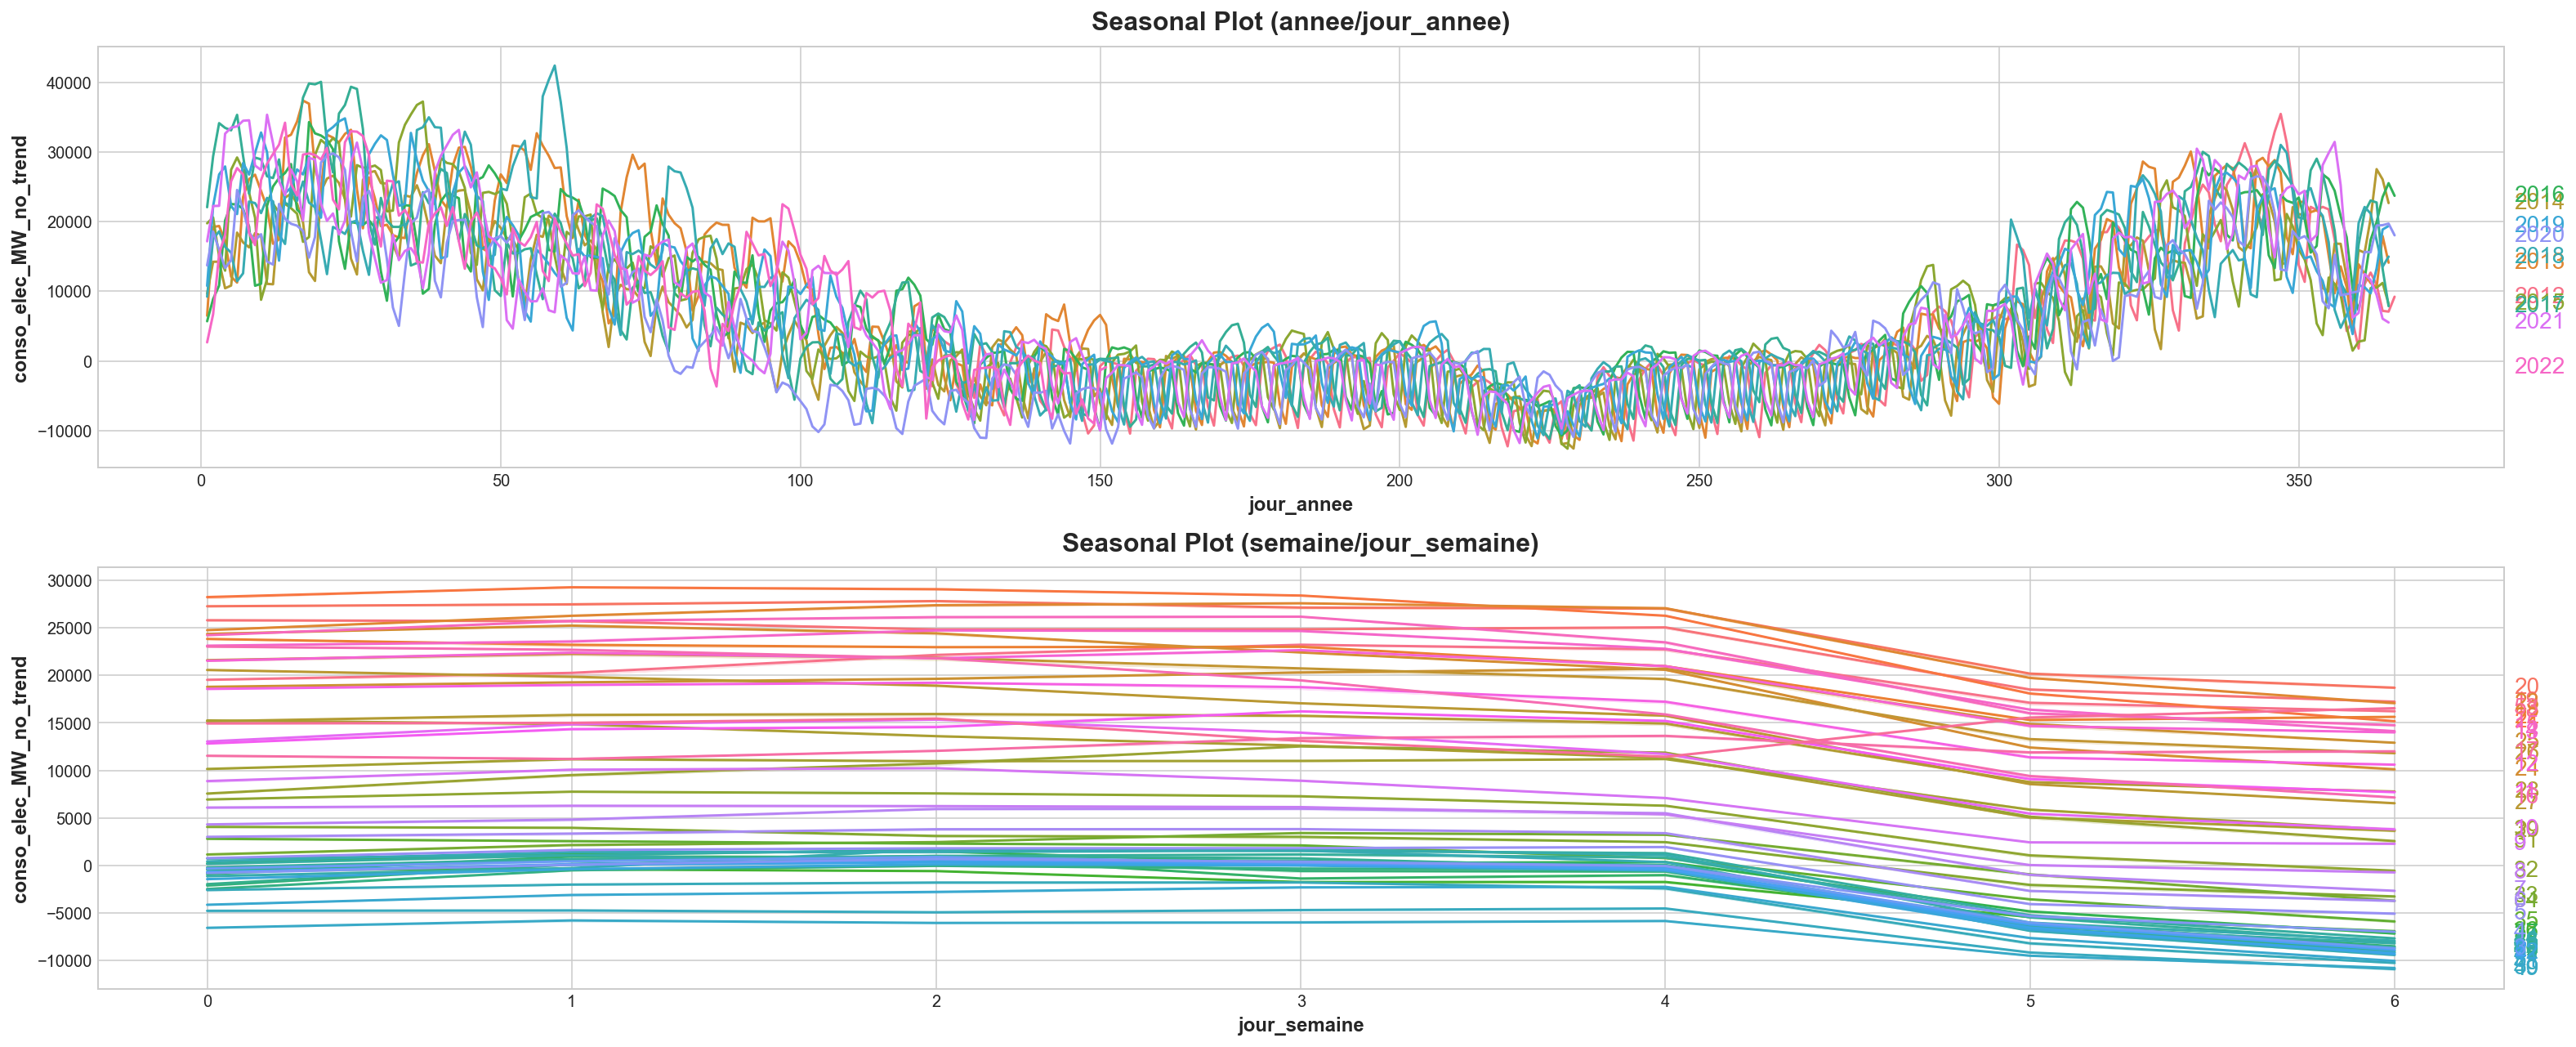

In [18]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(22, 9))
seasonal_plot(X, y="conso_elec_MW_no_trend", period="annee", freq="jour_annee", ax=ax0)
seasonal_plot(X, y="conso_elec_MW_no_trend", period="semaine", freq="jour_semaine", ax=ax1);

Un travail similaire est réalisé pour observation en fonction de l'heure de la journée.<br/>
Mais si il nécessite de se focaliser sur une période plus courte afin de pouvoir l'observer correctement.

In [19]:
debut = pd.to_datetime("2021-01-01").tz_localize("Europe/Paris")
fin = pd.to_datetime("2021-12-31 23:30:00").tz_localize("Europe/Paris")

In [20]:
X_heure = df_source[df_source.Date_parsed.between(debut,fin)]\
    .groupby(pd.Grouper(key='Date_parsed', axis=0, freq='H'))\
    .max()

In [21]:
X_heure["jour_annee"] = X_heure.index.dayofyear  # the x-axis (freq)
X_heure["heure"] = X_heure.index.hour  # the x-axis (freq)

In [22]:
X_heure.tail()

Conso_elec_totale_MW  conso_elec_MW_no_trend  \
Date_parsed                                                               
2021-12-31 19:00:00+01:00               57764.0             4915.348493   
2021-12-31 20:00:00+01:00               56180.0             3331.379323   
2021-12-31 21:00:00+01:00               53240.0              391.410153   
2021-12-31 22:00:00+01:00               52144.0             -704.543603   
2021-12-31 23:00:00+01:00               54396.0             1547.487227   

                           jour_annee  heure  
Date_parsed                                   
2021-12-31 19:00:00+01:00         365     19  
2021-12-31 20:00:00+01:00         365     20  
2021-12-31 21:00:00+01:00         365     21  
2021-12-31 22:00:00+01:00         365     22  
2021-12-31 23:00:00+01:00         365     23

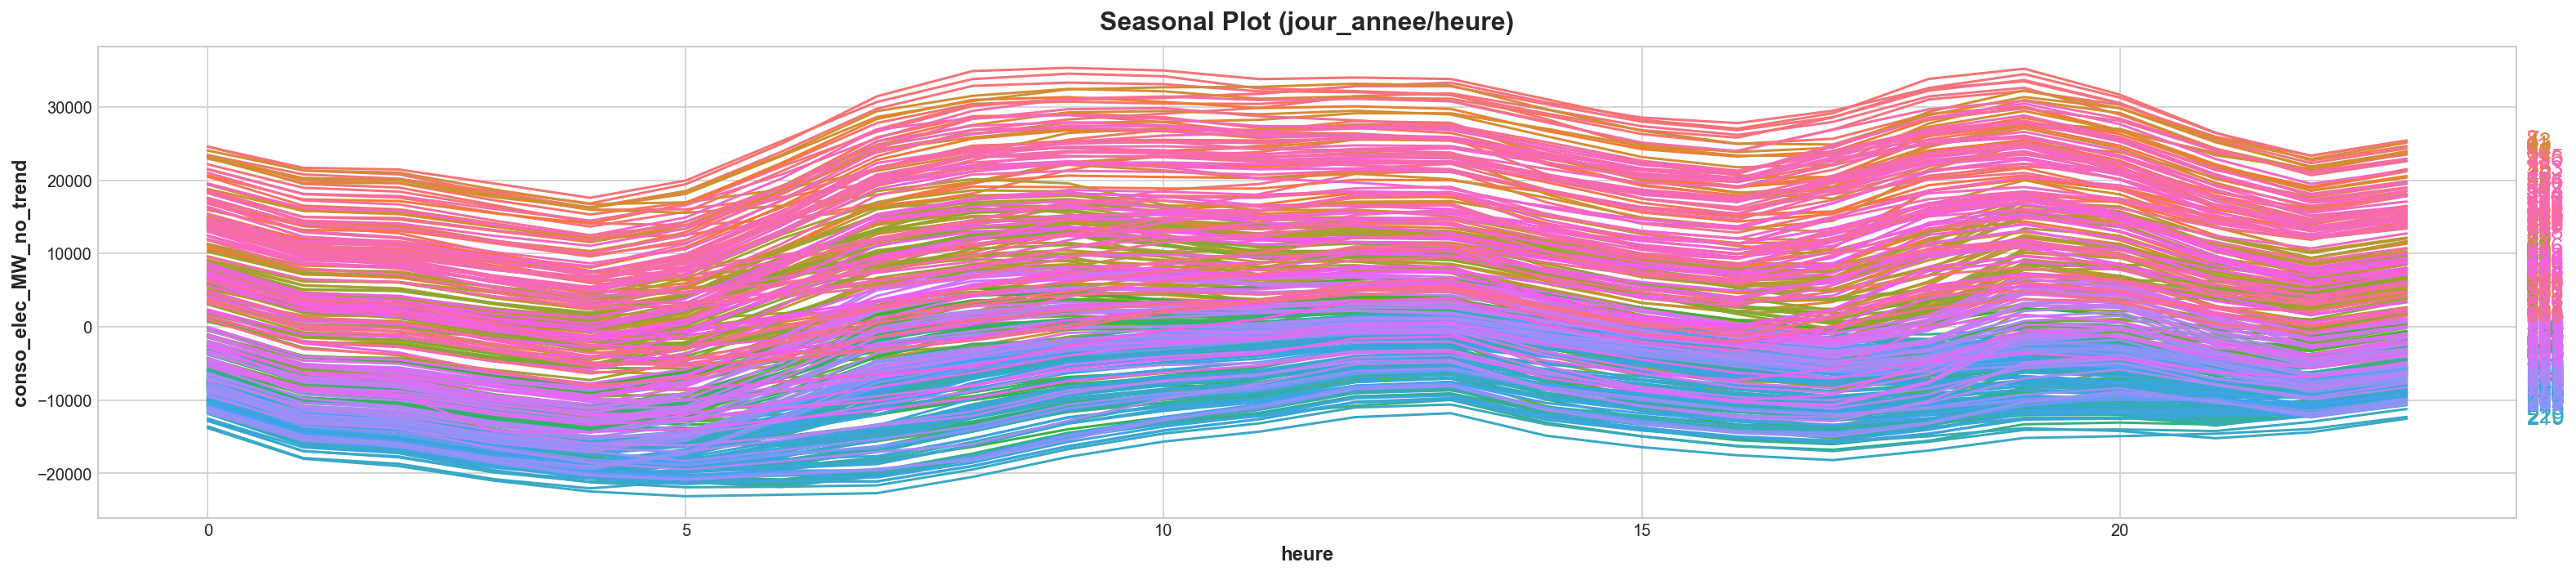

In [23]:
plt.rcParams['figure.figsize'] = [22, 5]
seasonal_plot(X_heure, y="conso_elec_MW_no_trend", period="jour_annee", freq="heure")
plt.show()

#### Conclusion ####
<p>
On observe plusieurs saisonnalités contenues dans notre courbe, de laquelle a été enlevée la tendance :
<li> D'un point de vue annuel, un maximum atteint en Février, puis décroissance pour nouveau pic en Décembre </li>
<li> Au niveau hebdomadaire, une très légère augmentation jusqu'au Mercredi, Jeudi, puis forte décroissance le week-end </li>
<li> En intra-journalier, une vague avec son maximum atteint vers 8h, puis une autre en fin de journée vers 19h</li>
</p>
<p>
Bien que les vagues ne soient pas symétriques ou régulière, ces occurences se répètent avec une grande régularité sur les 10 dernières années.<br/>
Nos séries de Fourier devront donc intégrer l'ensemble de ces saisonalités, afin de produire une courbe sinusoïdale, d'amplitudes voire de fréquence variables, pour modéliser cela le plus fidèlement possible
</p>

# Periodogrammes (Analyse spectrale) #

In [24]:
# Observation Max Quotidien
df_SF = df_source[["Date_parsed","Conso_elec_totale_MW"]].groupby(
    pd.Grouper(key='Date_parsed', axis=0, freq='D')
    ).max()\
    .squeeze()

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

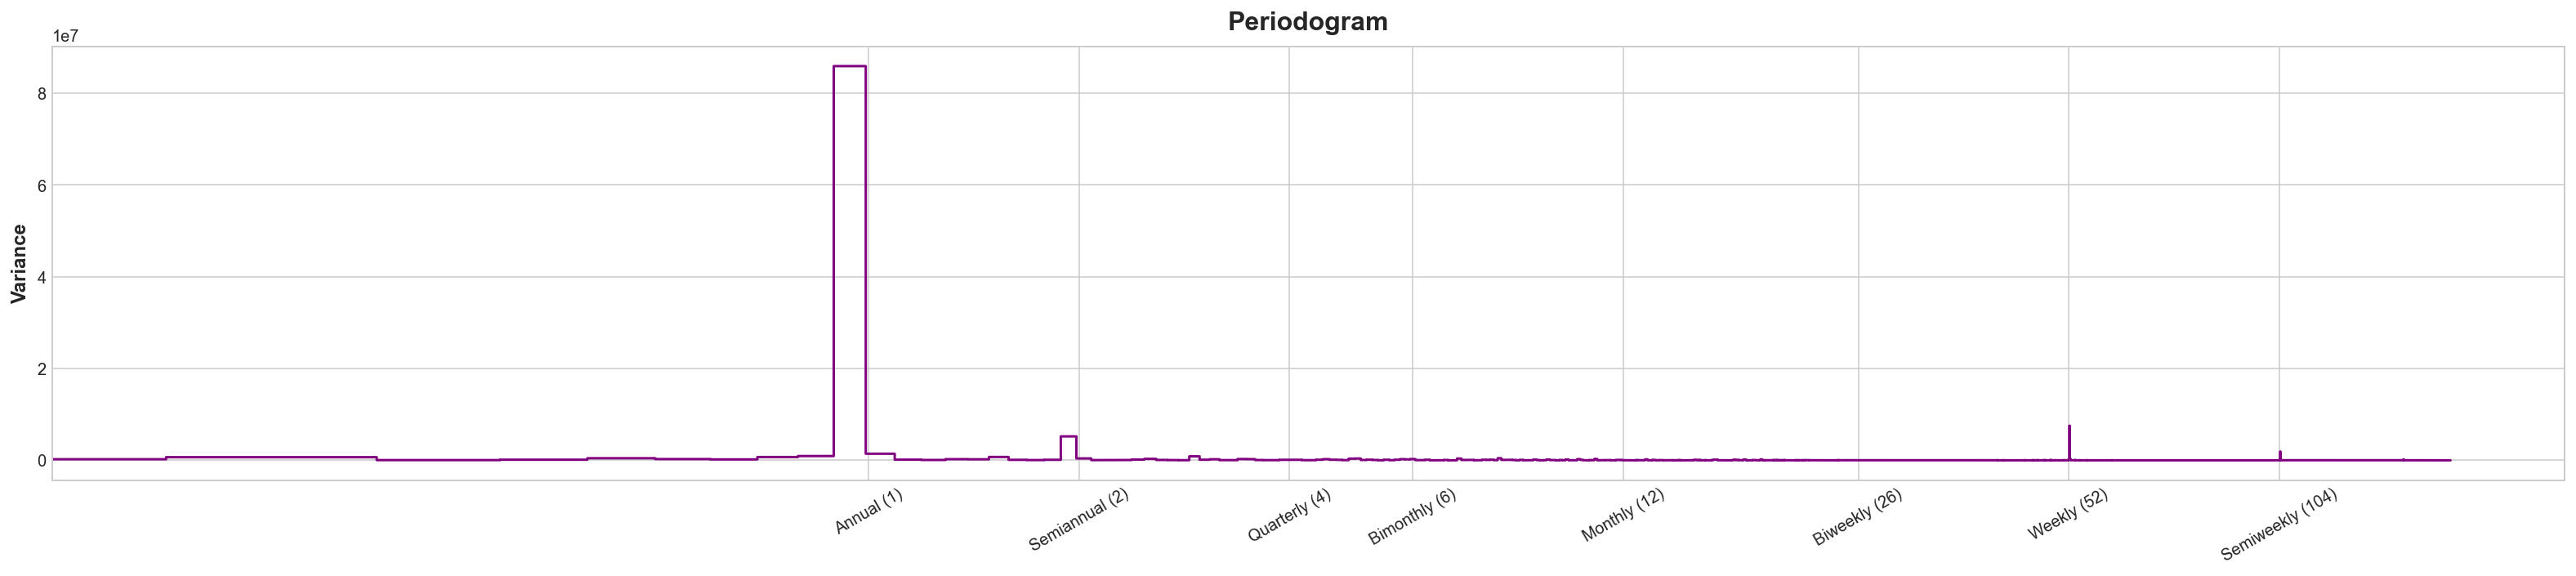

In [25]:
plot_periodogram(df_SF)

In [26]:
# Observation Max Quotidien
df_SF_h = df_source[df_source.Date_parsed.between(debut,fin)]\
    .groupby(pd.Grouper(key='Date_parsed', axis=0, freq='H'))\
    .max()

In [27]:
df_SF_h.interpolate(method='linear', axis=0, inplace=True)

In [28]:
df_SF_h.isna().sum()

Conso_elec_totale_MW      0
conso_elec_MW_no_trend    0
dtype: int64

In [29]:
df_SF_h = df_SF_h.drop(columns=["conso_elec_MW_no_trend"]).squeeze()

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

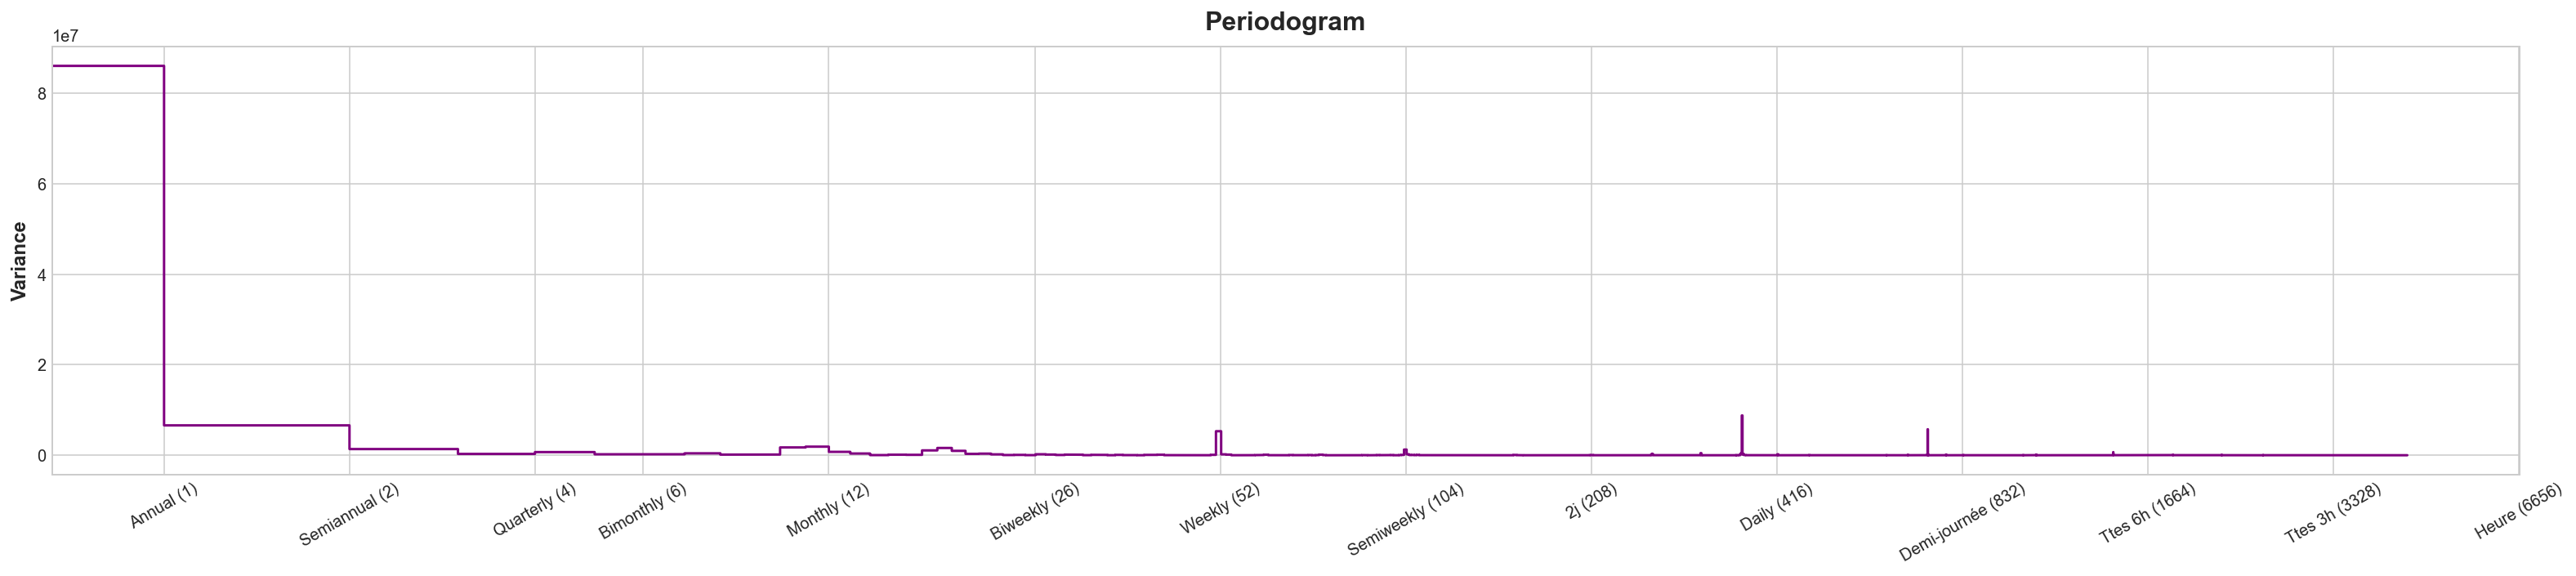

In [30]:
plot_periodogram_h(df_SF_h)

#### Interprétation ####
<p>Les periodogrammes montrent un pic très nettement plus important sur une base annuelle (l'équivalent de tous les hivers, par exemple).<br/>
Dans une moindre mesure bi-annuel, et le dernier pic visible est trimestriel.<br/>
Nous pourrons comparer dans les ordres de Fourier 1 (annuel), 2(bi-annuel) et 4(trimestriel).<br/>
Il faudra alors trouver le bon compromis entre généralisation et sur-entraînement.</p>
<p>De forts pics sont aussi visibles sur une base hebdo.<br/>
La saisonnalité hebdomadaire est générée différemment et plus facilement (paramètre seasonality = True dans dp).<br/>
Enfin, en ce qui concerne les jours, ainsi que les heures (ou moments de la journée) cela sera adréssé de différentes manières, dans le Notebook suivant.</p>

# Série de Fourier et prédiction #

In [41]:
# Pour travailler avec DeterministicProcess, qui va traiter simultanément la tendance et la saisonnalité
# On importe nos données raffinées, contenant encore la tenance
df_source_raff = pd.read_csv("sources/1_conso_energies_raff.csv")

In [42]:
# Puis l'on doit faire un travail identique de conversion des dates de str -> datetime
df_source_raff["Date_parsed"] = pd.to_datetime(df_source_raff["Date"], utc=True)
df_source_raff["Date_parsed"] = df_source_raff["Date_parsed"].dt.tz_convert('Europe/Paris')
df_source_raff.drop(columns='Date',inplace=True)

In [43]:
# Pour une meilleure visualisation, centrée sur le pic hivernal,
# mais aussi car les 1ère données de Janvier 2012 semblent assez anormales, on démarre en Mai 2012
# Le Dataset d'entraînement sera précisément sur 10 ans
hors_etude = df_source_raff.loc[ df_source_raff['Date_parsed']<="2012-04-30 23:30:00" ].index
df_source_raff.drop(index=hors_etude, inplace=True)

In [44]:
# Similaire à ce qui a été fait pour df_SF
y = df_source_raff[["Date_parsed","Conso_elec_totale_MW"]].groupby(
    pd.Grouper(key='Date_parsed', axis=0, freq='D')
    ).max()

In [45]:
# On ressort l'index pour en supprimer la timezone, DeterministicProcess ne marche pas sinon
y.reset_index(inplace=True)

In [46]:
# Suppression de la tz, et remise en index
y['Date_parsed'] = pd.to_datetime(y['Date_parsed'].dt.date)
y.set_index('Date_parsed', inplace=True)

In [51]:
y.tail()

Conso_elec_totale_MW
Date_parsed                      
2022-05-27                47213.0
2022-05-28                44486.0
2022-05-29                43756.0
2022-05-30                51405.0
2022-05-31                51851.0

In [48]:
y.shape[0]

3683

In [111]:
fourier = CalendarFourier(freq="A", order=5)  # 5 paires sin/cos, saisonnalité "A"nnual

In [112]:
print("La table d'entraînement contient : {} lignes.\nPériode 1er Mai 2012 au 31 Mai 2022.\nUnité de temps = jour".format(y.shape[0]))

La table d'entraînement contient : 3683 lignes.
Période 1er Mai 2012 au 31 Mai 2022.
Unité de temps = jour


In [113]:
# Génère artificiellement un index, sur la période étudiée. Au bon format datetime et sans timezone.
index = pd.period_range("2012-05-01", freq="D", periods=3683)

In [114]:
dp = DeterministicProcess(
    index,
    #period = ?                  # cf doc : https://www.statsmodels.org/stable/generated/statsmodels.tsa.deterministic.DeterministicProcess.html?highlight=deterministicprocess 
    constant=True,               # Si y-intercept, ce qui est le cas de la tendance
    order=1,                     # Ordre 1 = Linéaire 
    seasonal=True,               # Indicateurs auto pour saisonnalité hebdo
    additional_terms=[fourier],  # Séries de Fourier, pour toute autre fréquence qu'hebdo
    drop=True                    # Suppression des termes induisant collinéarité, si il y en a
)

In [115]:
X = dp.in_sample()  # create features for dates in tunnel.index

In [116]:
X.tail()

const   trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
2022-05-27    1.0  3679.0     0.0     0.0     1.0     0.0     0.0     0.0   
2022-05-28    1.0  3680.0     0.0     0.0     0.0     1.0     0.0     0.0   
2022-05-29    1.0  3681.0     0.0     0.0     0.0     0.0     1.0     0.0   
2022-05-30    1.0  3682.0     0.0     0.0     0.0     0.0     0.0     1.0   
2022-05-31    1.0  3683.0     0.0     0.0     0.0     0.0     0.0     0.0   

            sin(1,freq=A-DEC)  cos(1,freq=A-DEC)  sin(2,freq=A-DEC)  \
2022-05-27           0.587785          -0.809017          -0.951057   
2022-05-28           0.573772          -0.819015          -0.939856   
2022-05-29           0.559589          -0.828770          -0.927542   
2022-05-30           0.545240          -0.838280          -0.914128   
2022-05-31           0.530730          -0.847541          -0.899631   

            cos(2,freq=A-DEC)  sin(3,freq=A-DEC)  cos(3,freq=A-DEC)  \
2022-05-27           0.309017           0.951057           0.309017   
2022-05-28           0.341571           0.965740           0.259512   
2022-05-29           0.373720           0.977848           0.209315   
2022-05-30           0.405426           0.987349           0.158559   
2022-05-31           0.436651           0.994218           0.107381   

            sin(4,freq=A-DEC)  cos(4,freq=A-DEC)  sin(5,freq=A-DEC)  \
2022-05-27          -0.587785          -0.809017      -4.898587e-16   
2022-05-28          -0.642055          -0.766659       8.596480e-02   
2022-05-29          -0.693281          -0.720667       1.712931e-01   
2022-05-30          -0.741222          -0.671260       2.553533e-01   
2022-05-31          -0.785650          -0.618671       3.375229e-01   

            cos(5,freq=A-DEC)  
2022-05-27           1.000000  
2022-05-28           0.996298  
2022-05-29           0.985220  
2022-05-30           0.966848  
2022-05-31           0.941317

In [117]:
# Isolation de la cible pour entraînement puis prédiction
y = y.squeeze()
y

Date_parsed
2012-05-01    51830.0
2012-05-02    59098.0
2012-05-03    58288.0
2012-05-04    57722.0
2012-05-05    52155.0
               ...   
2022-05-27    47213.0
2022-05-28    44486.0
2022-05-29    43756.0
2022-05-30    51405.0
2022-05-31    51851.0
Name: Conso_elec_totale_MW, Length: 3683, dtype: float64

In [118]:
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

In [119]:
y_pred = pd.Series(model.predict(X), index=y.index)

In [120]:
# 7 mois -> 210j
X_fore = dp.out_of_sample(steps=547)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

#### Viusaliation des prédictions #### 
Affichage "grossi", avec début en  2019 pour mieux apprécier les variations de courbes.

In [121]:
y_2019 = y[(y.index >= "2019-06-01") == True]
y_pred_2019 = y_pred[(y_pred.index >= "2019-06-01") == True]

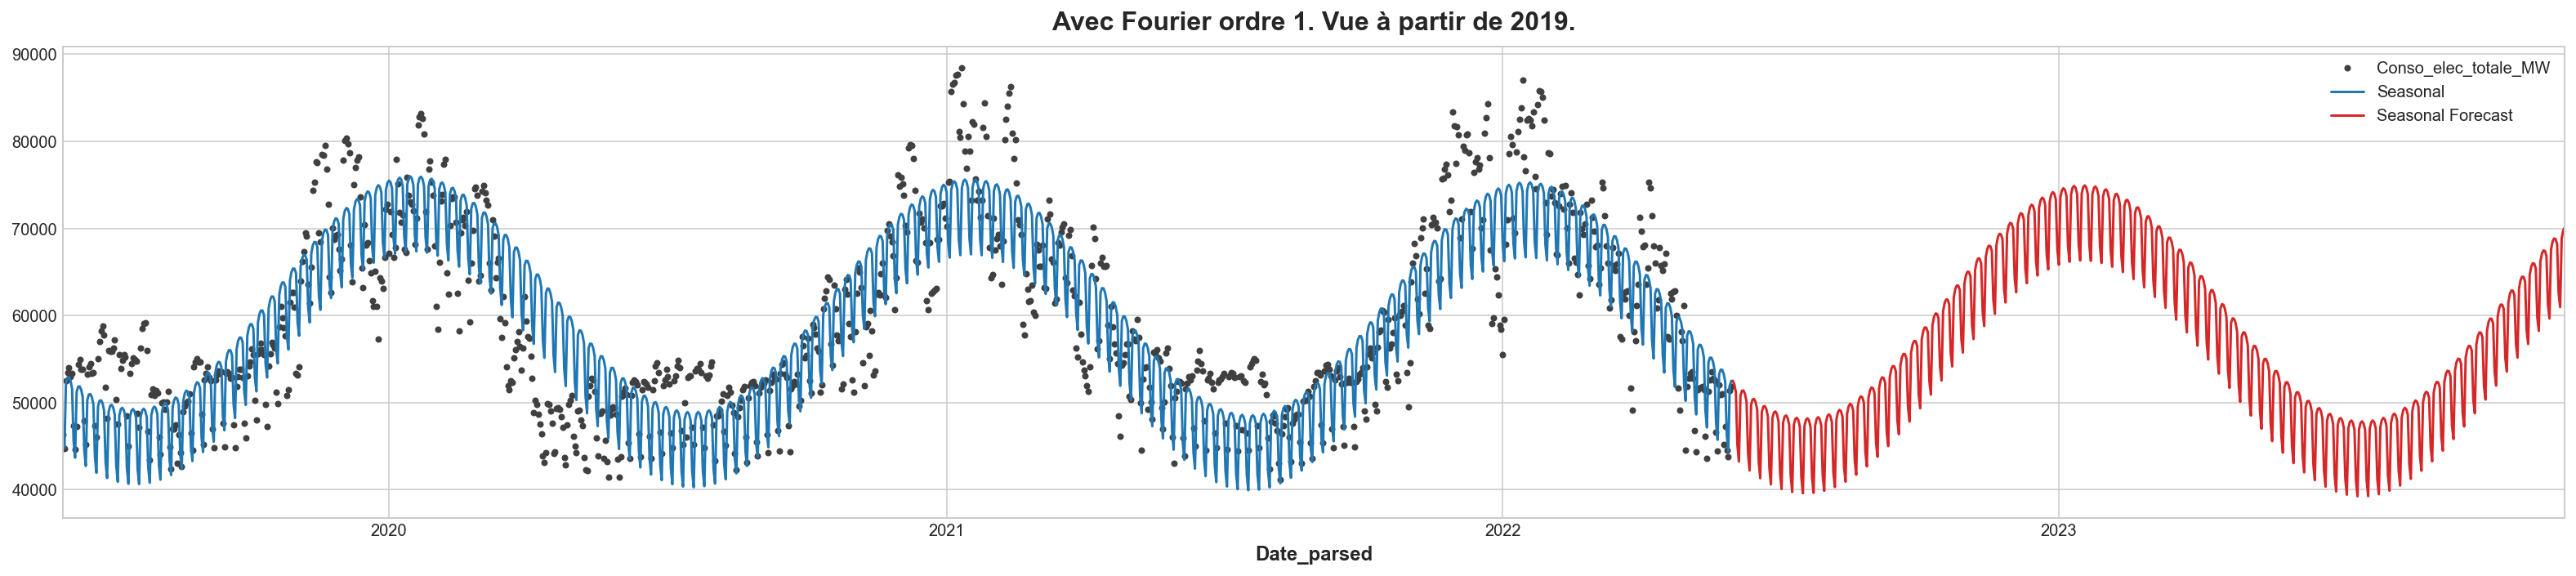

In [74]:
ax = y_2019.plot(color='0.25', style='.', title="Avec Fourier ordre 1. Vue à partir de 2019.")
ax = y_pred_2019.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

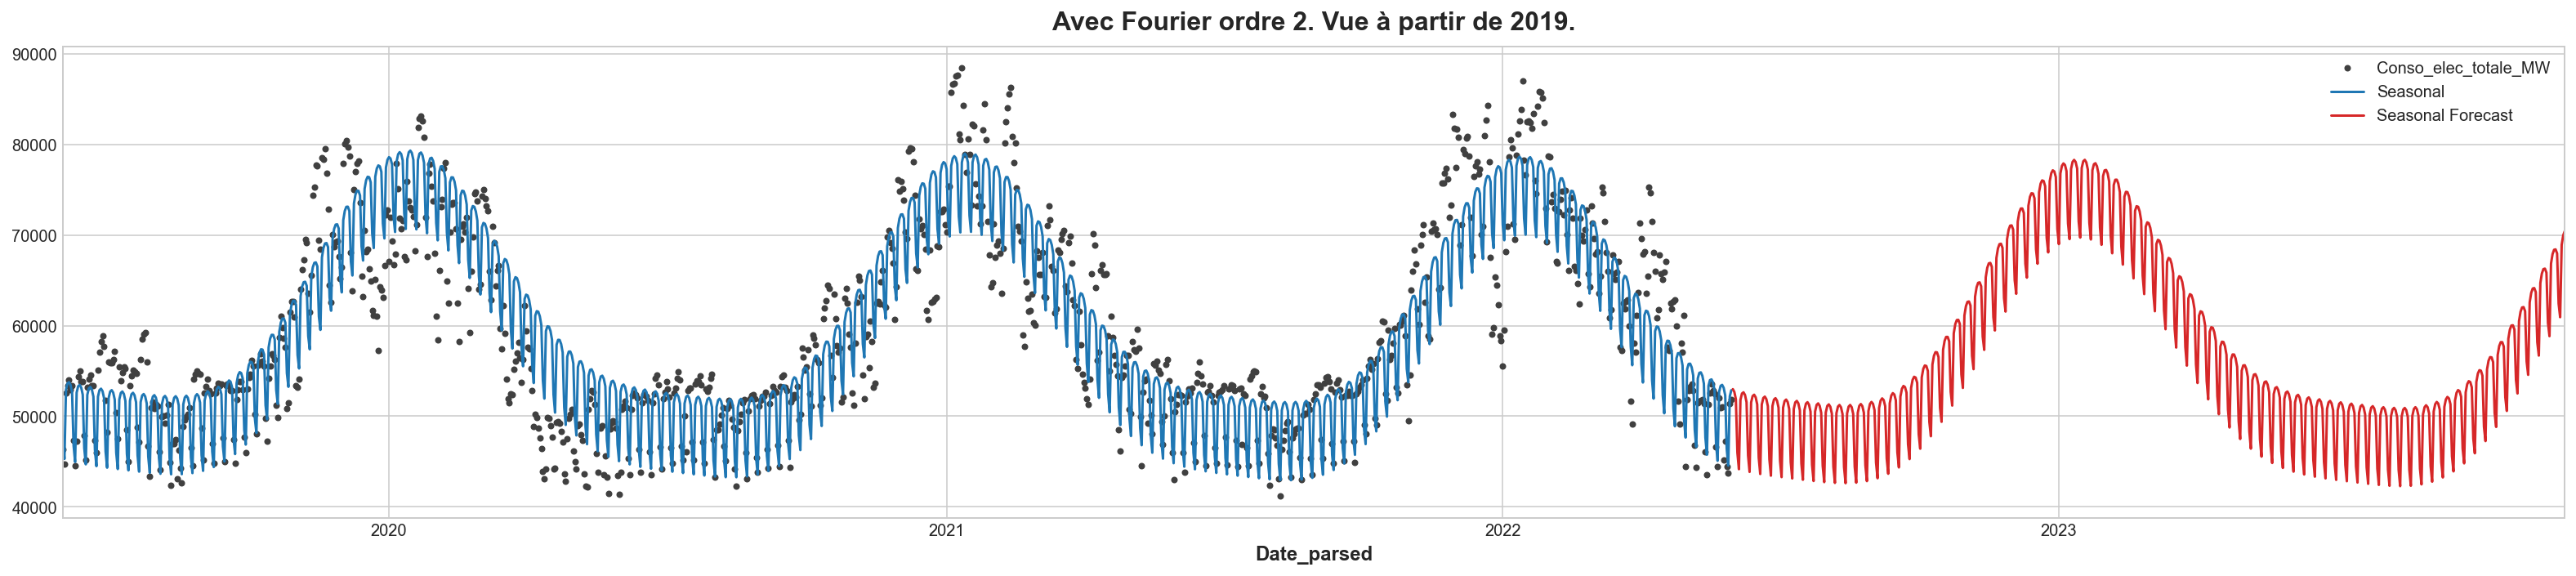

In [86]:
ax = y_2019.plot(color='0.25', style='.', title="Avec Fourier ordre 2. Vue à partir de 2019.")
ax = y_pred_2019.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

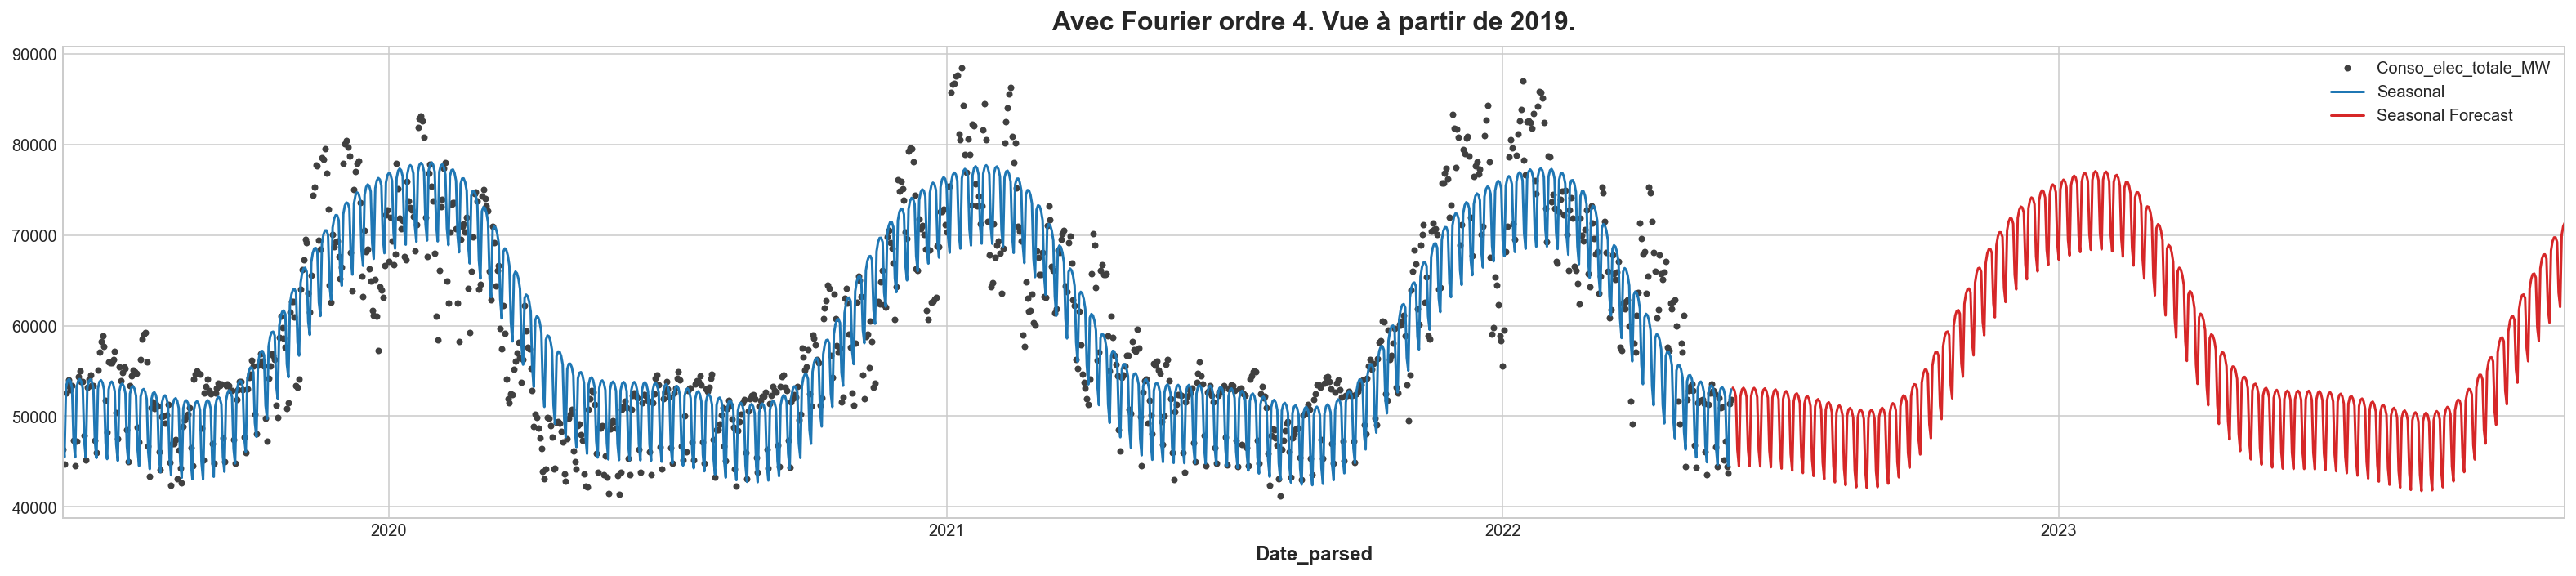

In [110]:
ax = y_2019.plot(color='0.25', style='.', title="Avec Fourier ordre 4. Vue à partir de 2019.")
ax = y_pred_2019.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

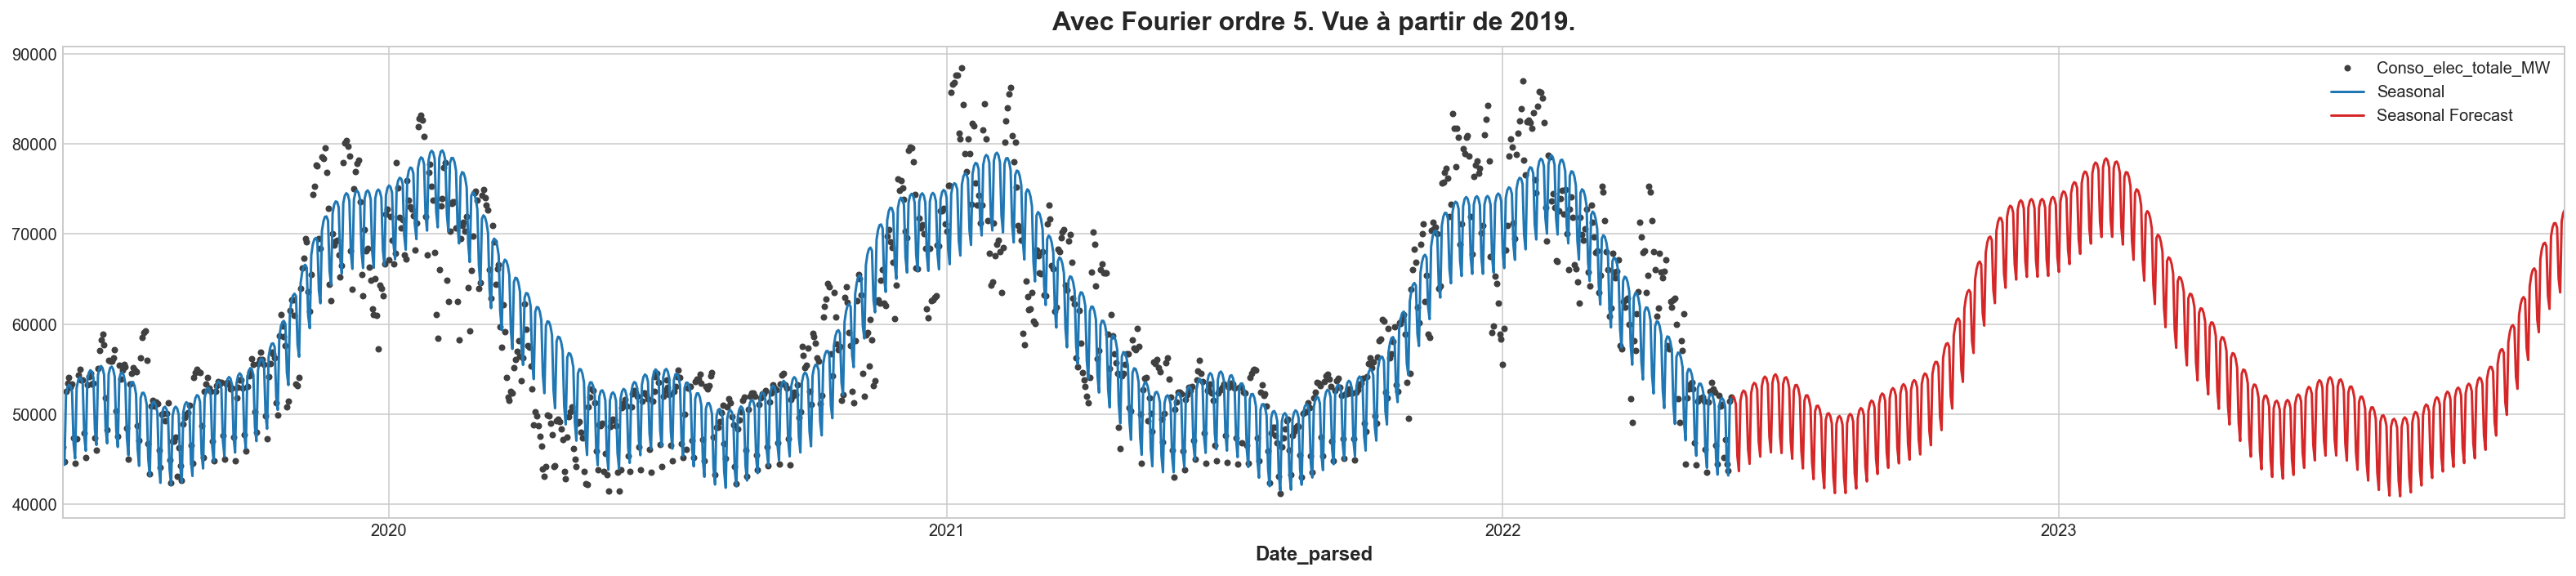

In [122]:
ax = y_2019.plot(color='0.25', style='.', title="Avec Fourier ordre 5. Vue à partir de 2019.")
ax = y_pred_2019.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

Vue sur l'intégralité du Dataset + prédiction à fin 2024

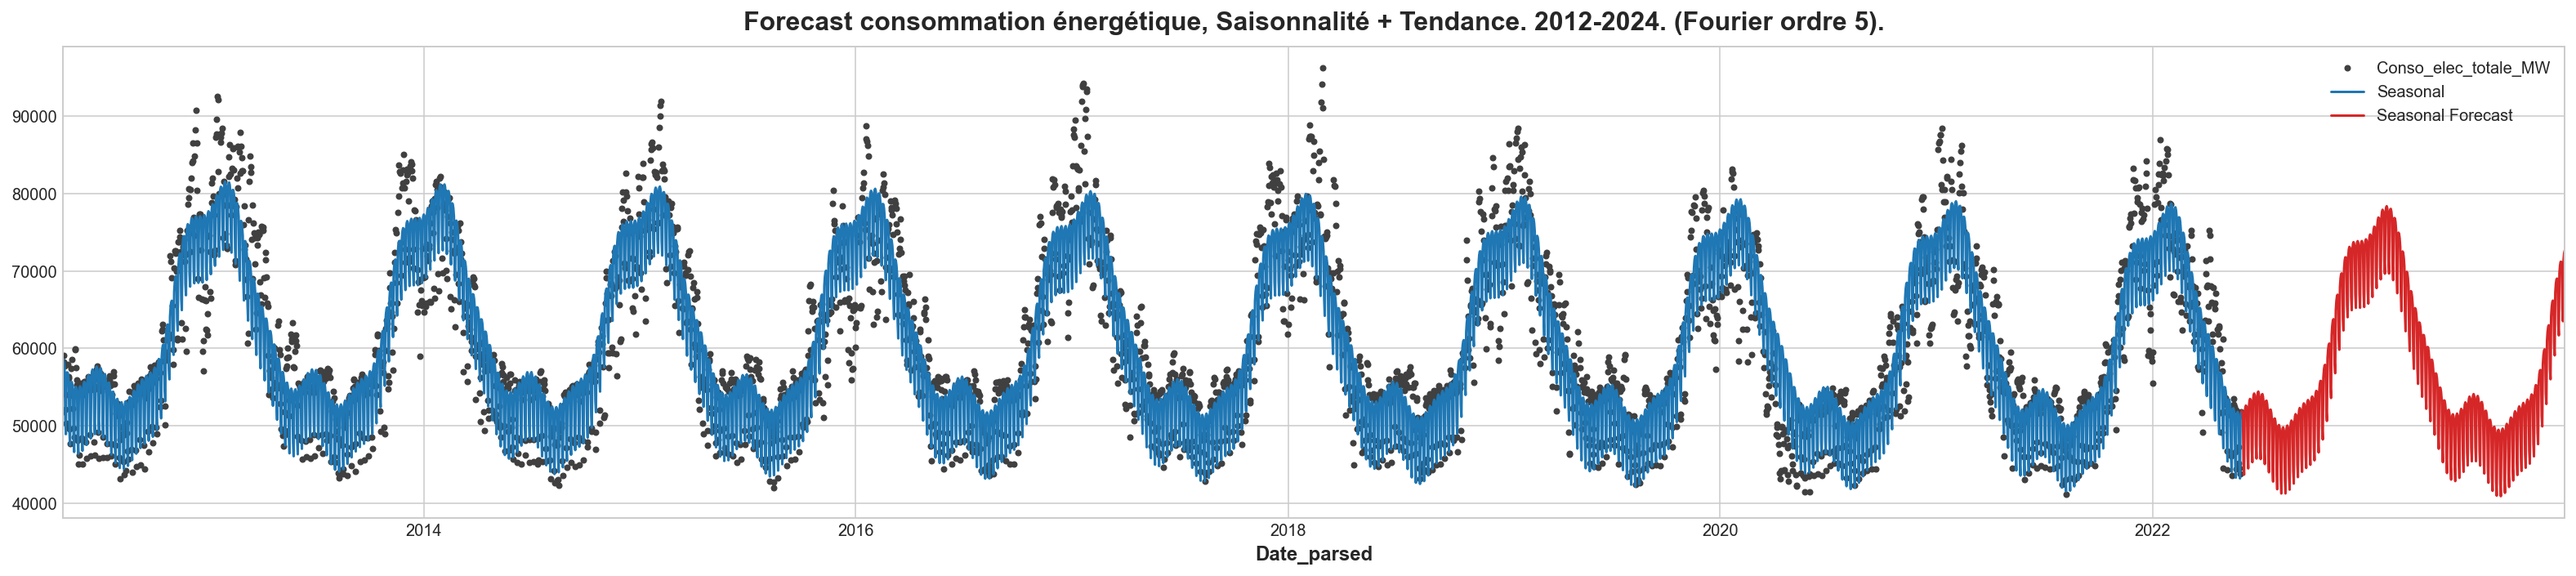

In [123]:
ax = y.plot(color='0.25', style='.', title="Forecast consommation énergétique, Saisonnalité + Tendance. 2012-2024. (Fourier ordre 5).")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

# Contrôle de la suppression de la saisonnalité + Tendance #
Et export pour prochain traitement

En effet, bien que le modèle suive, à l'ordre 4, assez précisément la consommation énergetique avec le profil suivant :
<li>Cycle principal à chaque hiver</li>
<li>Suivi d'une rapide décroissance, une consommation faible avec une baseline elle même en décroissance, au printemps et à l'été</li>
<li>Une remontée assez forte, mais avec un profil en plateau à son maximum, de l'automne au pic de l'hiver</li>

<p>Il n'en demeure pas moins que les pics de consommation qui surviennent courant Janvier - Février ne sont pas bien assimilés par le modèle.</br>
Ils sont pourtant au final l'enjeu de la prédiction, qui pourrait être utilisée afin d'anticiper un "blackout".<br/>
Cette gestion de ce qui peut être assimilé à des "outiliers" sera traitée par la prise en compte de lags, ou d'ajout de Features <br/>
(ex : vacances ? météo ? moment de la journée ? autres), dans les prochains notebooks.</p>

<p>Nous contrôllons d'abord que tout résidu de saisonnalité à bien été traité, et intégré au modèle</p>

In [124]:
y_deseason = y - y_pred

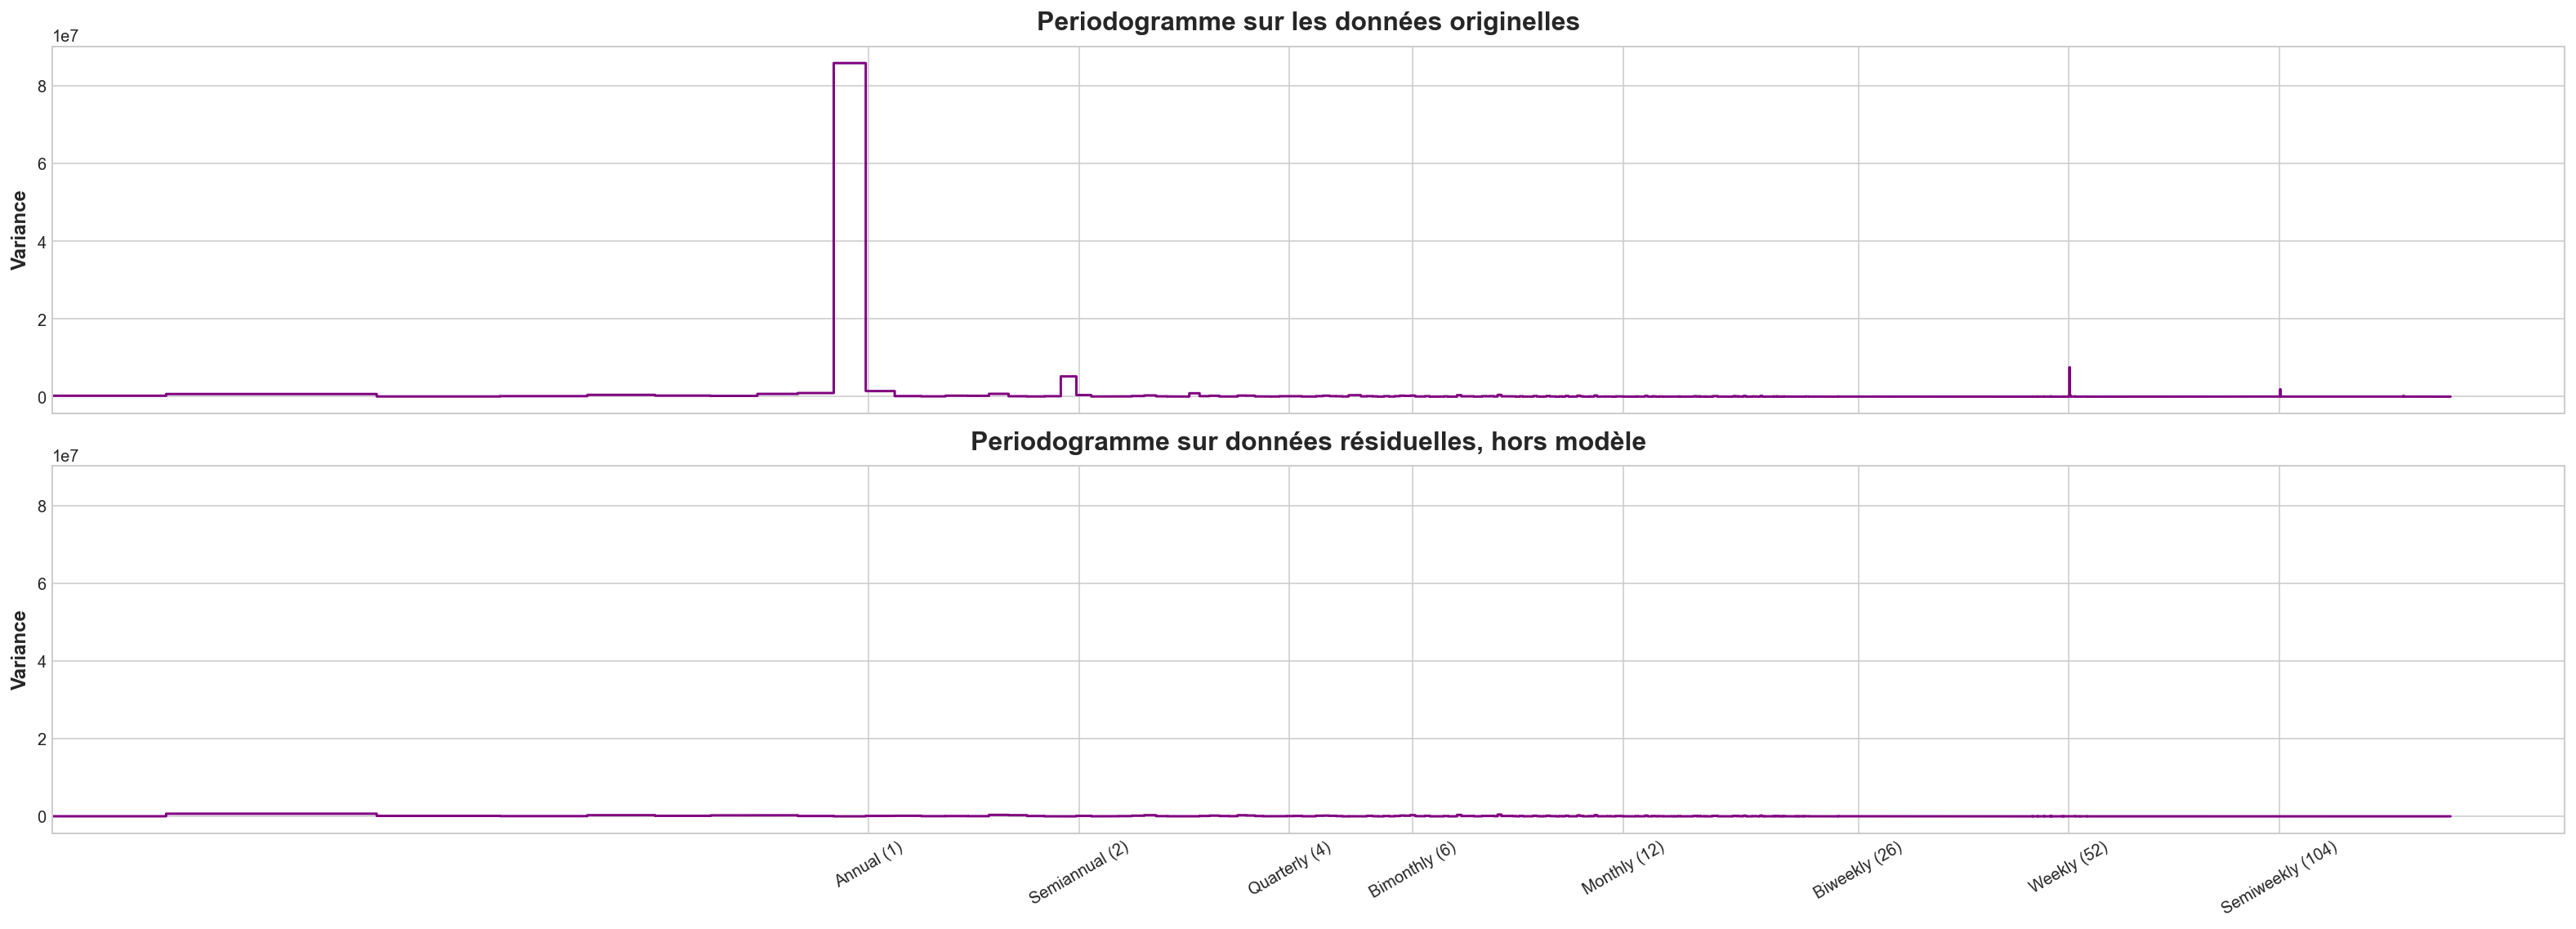

In [125]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(22, 8))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Periodogramme sur les données originelles")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Periodogramme sur données résiduelles, hors modèle");

<p>Les principales composantes ont bien été prises en compte.<br />
<b>REMARQUE</b> : Fourier sélectionné à l'ordre 5 (qui correspond à une période de 12/5 mois ?!).<br/> 
En effet, si on se limite au trimestre (4) le pic en Quarterly & Bimonthly persiste. Indiquant qu'une saisonnalité persiste et n'a pas été prise en compte.<br/>
Cela n'est pas franchement visible à l'oeil nu (équivalent à une périodicité de 73j ?!), mais c'est mathématiquement le plus précis.</p>
<p>Ci-après, l'affichage du "bruit résiduel" non pris en compte par le modèle.<br/>
C'est à dire les pics non anticipés que l'on va chercher à prédire par la suite.</p>

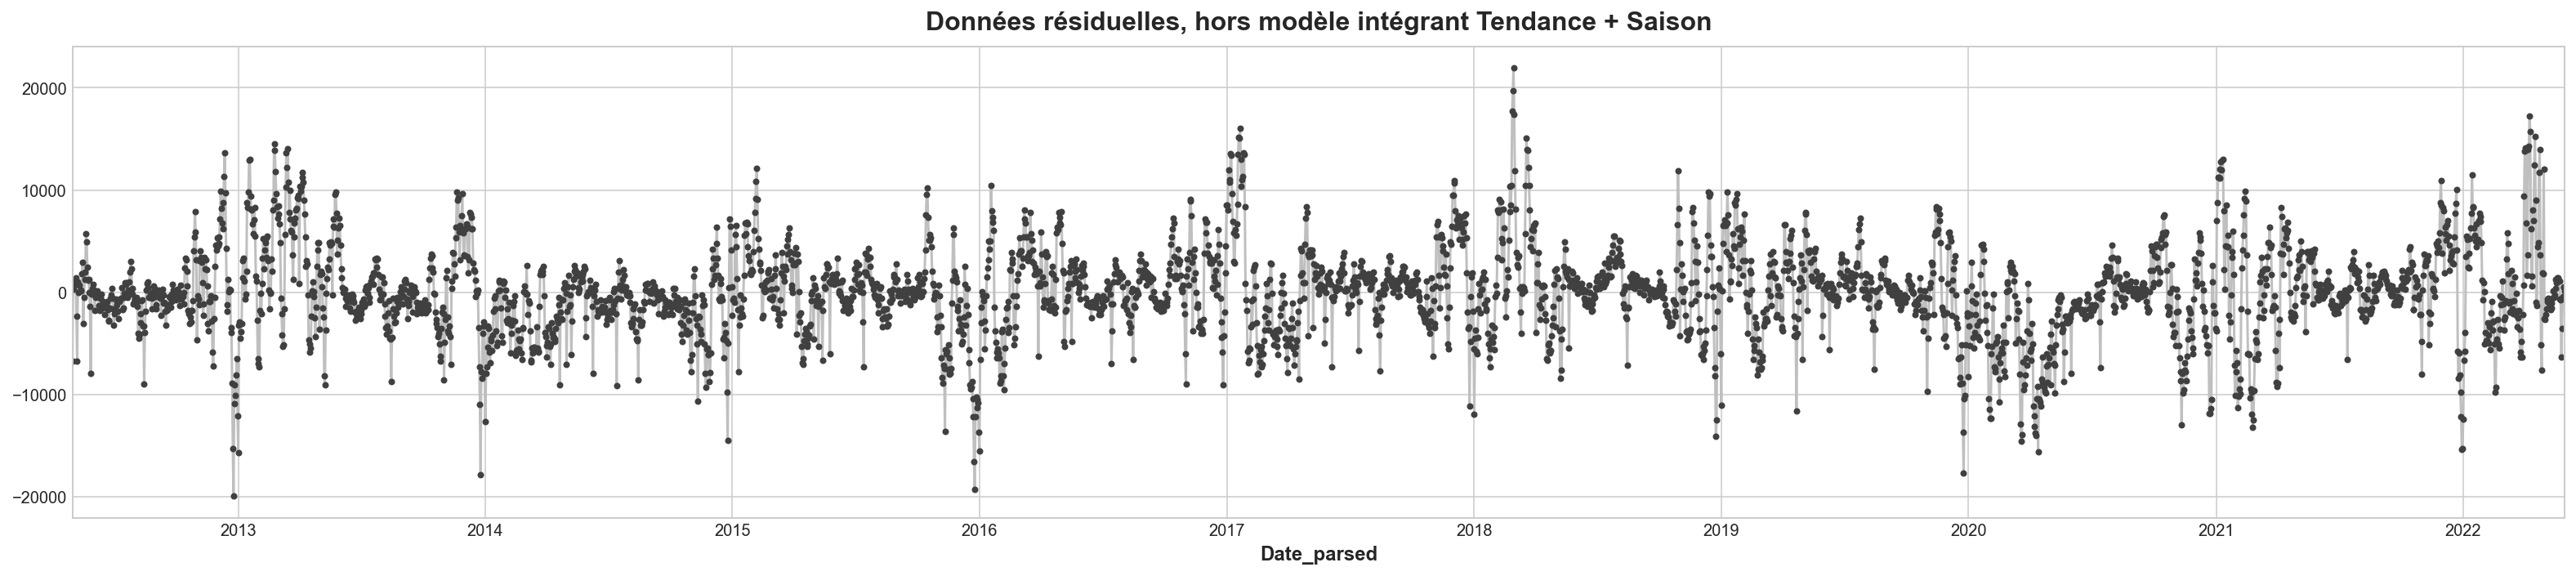

In [128]:
ax = y_deseason.plot(**plot_params)
ax.set_title('Données résiduelles, hors modèle intégrant Tendance + Saison');

Le résidu n'a clairement pas de tendance.<br/>
Peu de saisonnalité : les pics persistent à l'hiver. Mais pas toujours (voir 2014,2020).<br/>
Les pics mesurés montent généralement à +10.000 MW.<br/>
Ce qui n'est pas négligeable en terme d'énergie à produire.<br/>
Néanmoins cela signifie aussi que, notre modèle qui oscille entre 45k MW et 80MW en période de pic hivernal, capte déjà 71% de l'amplitude.<br/>

In [127]:
df_deseason = pd.DataFrame(y_deseason)
df_deseason.reset_index(inplace=True)
df_deseason.columns = ["Date","Résidus"]
df_deseason.to_csv("sources/residus_noTrend_noSeason.csv", header=True)

# Test en granularité heure ou demi-heure #

In [129]:
df_source_raff.head(1)

Conso_gaz_totale_MW  Conso_elec_totale_MW     Statut  \
5808              34489.0               51830.0  Définitif   

      Conso_brute_totale_MW  MA_max_7j               Date_parsed  
5808                86319.0    62482.0 2012-05-01 00:00:00+02:00

In [134]:
# Observation Max Quotidien
df_fourier_h = df_source_raff.groupby(pd.Grouper(key='Date_parsed', axis=0, freq='H'))\
    .max()

In [135]:
df_fourier_h.shape[0]

88392

In [156]:
df_fourier_h.isna().sum()

Conso_gaz_totale_MW      10
Conso_elec_totale_MW     10
Statut                   10
Conso_brute_totale_MW    10
MA_max_7j                10
dtype: int64

In [159]:
df_fourier_h.interpolate(method='linear', axis=0, inplace=True)

In [160]:
df_fourier_h.isna().sum()

Conso_gaz_totale_MW       0
Conso_elec_totale_MW      0
Statut                   10
Conso_brute_totale_MW     0
MA_max_7j                 0
dtype: int64

In [161]:
type(df_fourier_h.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [162]:
# Conversion de l'index de DatetimeIndex -> PeriodIndex necessaire pour traitement par DeterministicProcess
df_fourier_h.index.to_period("H")

PeriodIndex(['2012-05-01 00:00', '2012-05-01 01:00', '2012-05-01 02:00',
             '2012-05-01 03:00', '2012-05-01 04:00', '2012-05-01 05:00',
             '2012-05-01 06:00', '2012-05-01 07:00', '2012-05-01 08:00',
             '2012-05-01 09:00',
             ...
             '2022-05-31 14:00', '2022-05-31 15:00', '2022-05-31 16:00',
             '2022-05-31 17:00', '2022-05-31 18:00', '2022-05-31 19:00',
             '2022-05-31 20:00', '2022-05-31 21:00', '2022-05-31 22:00',
             '2022-05-31 23:00'],
            dtype='period[H]', name='Date_parsed', length=88392)

In [163]:
fourier = CalendarFourier(freq="A", order=5)  # 5 paires sin/cos, saisonnalité "A"nnual

In [164]:
dp_h = DeterministicProcess(
    index = df_fourier_h.index.to_period("H"),
    #period = ?                  # cf doc : https://www.statsmodels.org/stable/generated/statsmodels.tsa.deterministic.DeterministicProcess.html?highlight=deterministicprocess 
    constant=True,               # Si y-intercept, ce qui est le cas de la tendance
    order=1,                     # Ordre 1 = Linéaire 
    seasonal=True,               # Indicateurs auto pour saisonnalité hebdo
    additional_terms=[fourier],  # Séries de Fourier, pour toute autre fréquence qu'hebdo
    drop=True                    # Suppression des termes induisant collinéarité, si il y en a
)

In [168]:
X_h = dp_h.in_sample()

In [169]:
y_h = df_fourier_h[["Conso_elec_totale_MW"]].squeeze()

In [170]:
model2 = LinearRegression(fit_intercept=False)
_ = model2.fit(X_h, y_h)

In [171]:
y_h_pred = pd.Series(model2.predict(X_h), index=y_h.index)

In [173]:
# 7 mois -> 210j * 24h = 5040 lignes
X_h_fore = dp_h.out_of_sample(steps=5040)
y_h_fore = pd.Series(model2.predict(X_h_fore), index=X_h_fore.index)

In [176]:
#### Viusaliation des prédictions #### 
#Affichage "grossi", avec début en  2019 pour mieux apprécier les variations de courbes.
y_h_2020 = y_h[(y_h.index >= "2020-06-01 00:00:00") == True]
y_h_pred_2020 = y_h_pred[(y_h_pred.index >= "2020-06-01 00:00:00") == True]

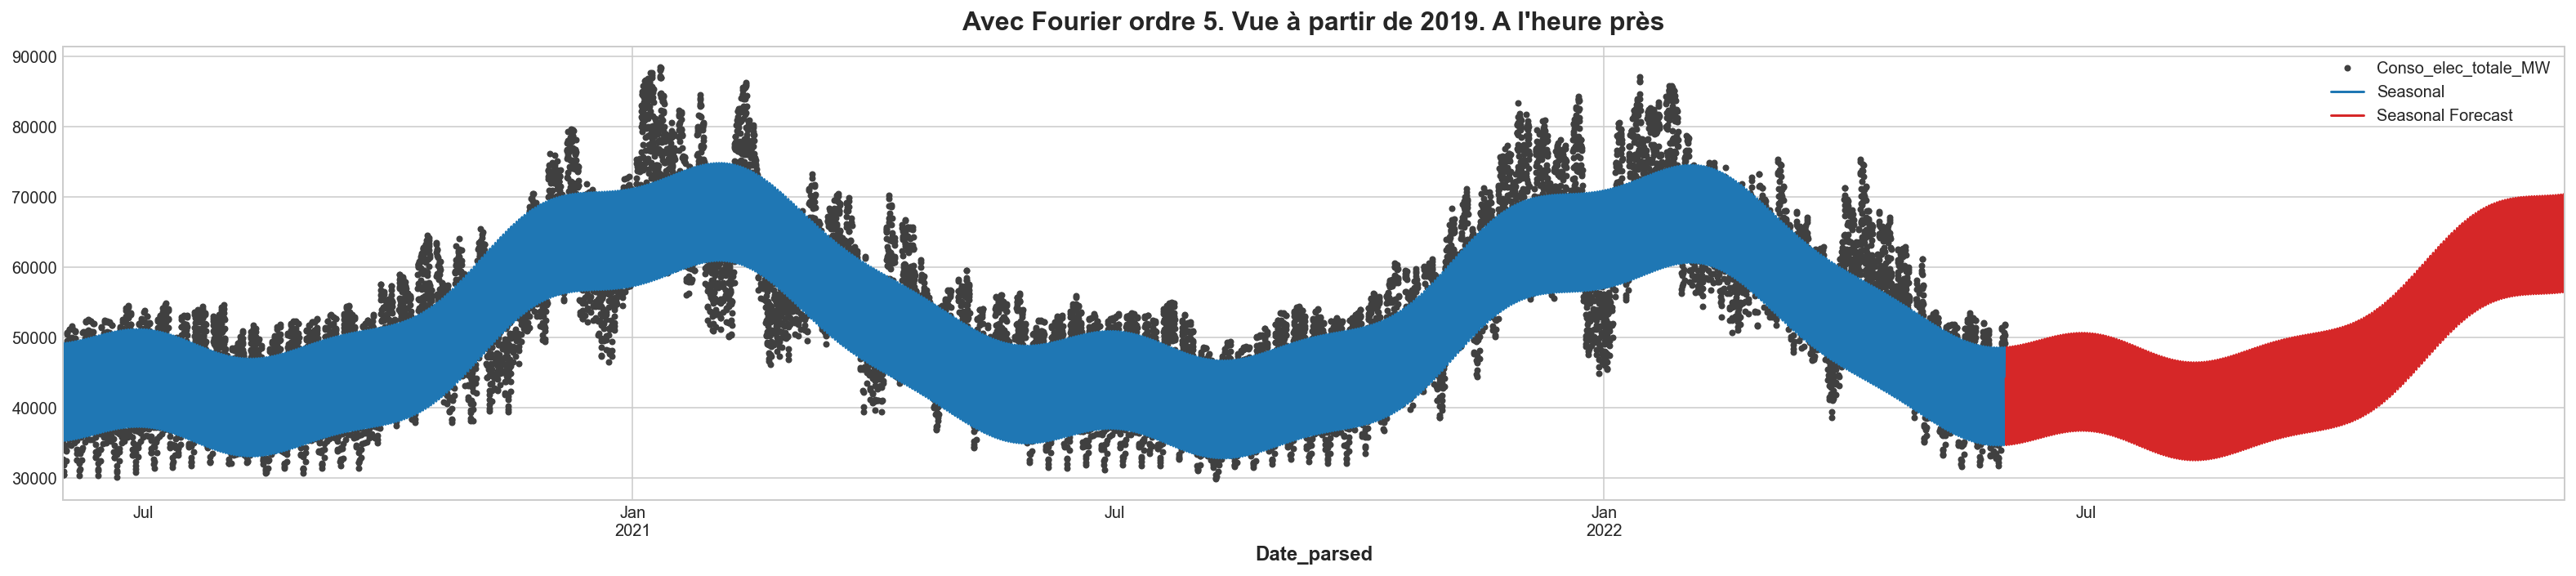

In [177]:
ax = y_h_2020.plot(color='0.25', style='.', title="Avec Fourier ordre 5. Vue à partir de 2019. A l'heure près")
ax = y_h_pred_2020.plot(ax=ax, label="Seasonal")
ax = y_h_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

Les données sont plus denses, la précision du modèle n'est cependant pas accrue

In [178]:
y_h_deseason = y_h - y_h_pred

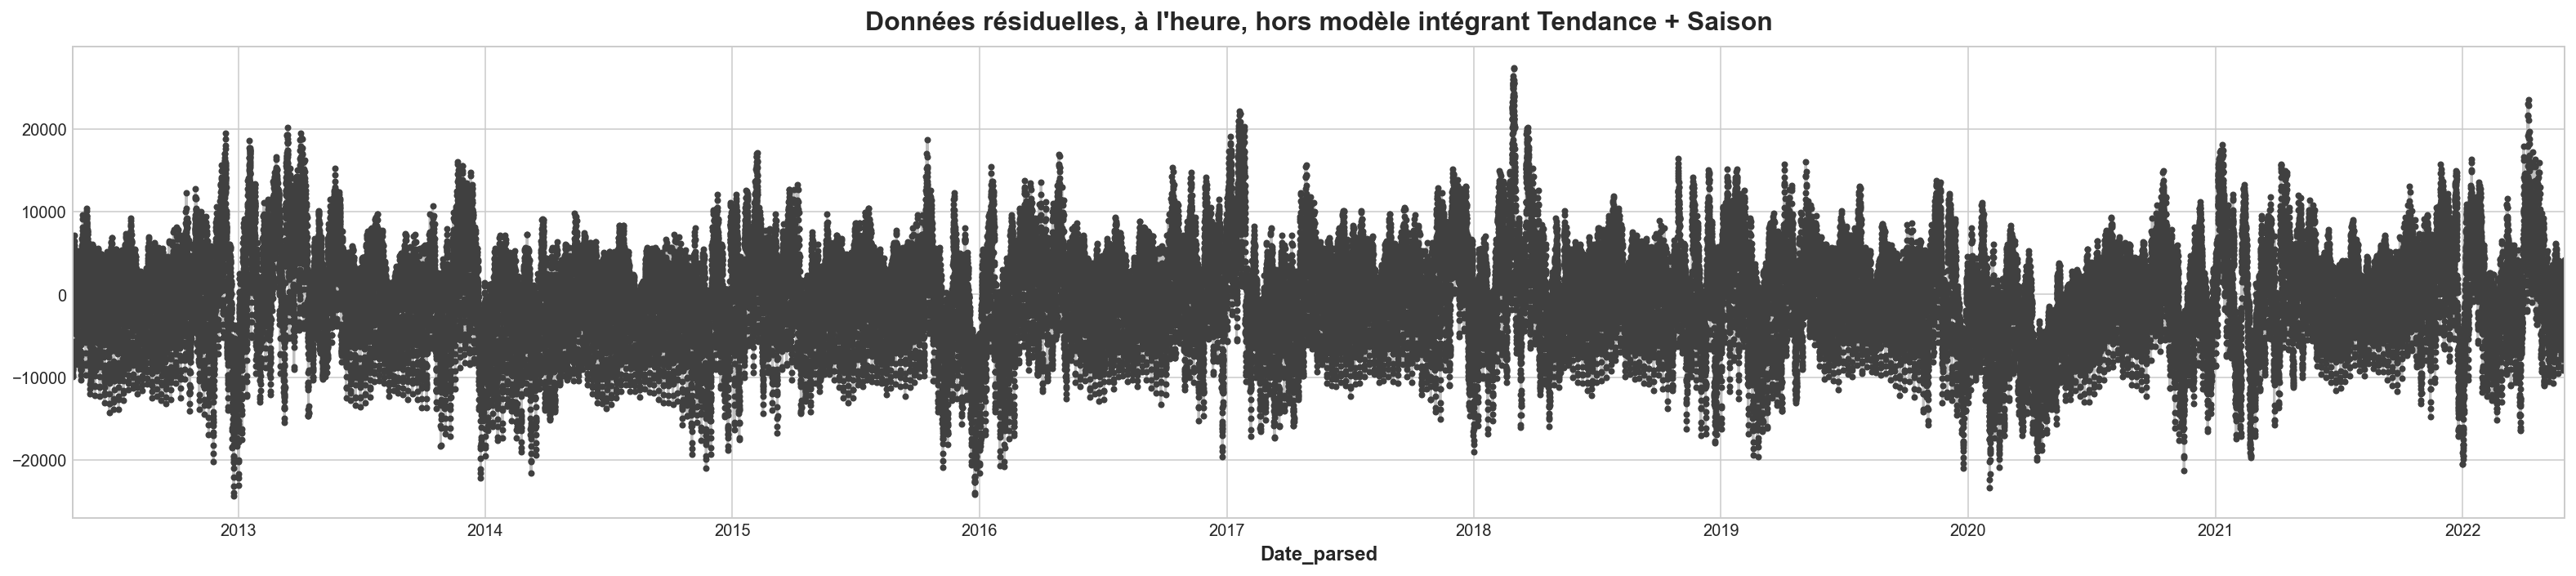

In [179]:
ax = y_h_deseason.plot(**plot_params)
ax.set_title("Données résiduelles, à l'heure, hors modèle intégrant Tendance + Saison");

In [180]:
df_deseason_h = pd.DataFrame(y_h_deseason)
df_deseason_h.reset_index(inplace=True)
df_deseason_h.columns = ["Date","Résidus_h"]
df_deseason_h.to_csv("sources/residus_h_noTrend_noSeason.csv", header=True)